In [ ]:
# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction

In [266]:
#!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
### the meaning of prediction about stock market
from numpy.core.numeric import ones_like
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [265]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
  #df_data.head()
  return df_data

def get_df_data_update(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09", interval_len='1d'):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time, interval=interval_len) 
  #df_data.head()
  return df_data

# calculate the daily return by (current_index - previous_index) / previous_index
def calculate_daily_return(df_data, OHLC_index="Close"):
  name1 = OHLC_index+"_previous"
  df_data[name1] = df_data[OHLC_index].shift(1)
  name2 = OHLC_index+"_delta"
  df_data[name2] = df_data[OHLC_index] - df_data[name1]
  name3 = OHLC_index+"_return"
  df_data[name3] = df_data[name2] / df_data[name1]
  del df_data[name1]
  del df_data[name2]
  new_feature = name3
  return df_data #, new_feature

# get the market movement (yesterday -> today) based on daily return, 
  # 1 means rise and 0 fall
def get_market_movement(df_data, signal_name="Close_return"):
  df_data["movement"] = df_data[signal_name]>0
  df_data["movement"] = df_data["movement"].astype(int)
  return df_data

# convert the time to be string type: yyyy-mm-dd
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  # month
  df_data["monthNumber"] = df_data["ymd_time"].str.slice(5,7)
  df_data["monthNumber"] = df_data["monthNumber"].astype(int)
  # week
  df_data['ymd_time'] = pd.to_datetime(df_data['ymd_time'], errors ='coerce')
  df_data['weekNumber'] = df_data['ymd_time'].dt.isocalendar().week
  return df_data

# calculate basic-level strategy: buy & hold
def basic_level_startegy(df_data, feature_name="Close_return"):
  daily_return_list = list( df_data[feature_name] )
  base_money = 1.0
  for change in daily_return_list:
    # math.isnan(daily_return_list[0])
    if not math.isnan(change):
      base_money = base_money * (1+change)
  # 
  return base_money

# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction
def generate_permutation(random_seed, list_len, accuracy_ratio):
  ones = int(accuracy_ratio * list_len)
  zeros = list_len - ones
  a_list = []
  for i in range(ones):
    a_list.append(1)
  for i in range(zeros):
    a_list.append(0)
  random.seed(random_seed)
  random.shuffle(a_list)
  return a_list

# 
def prediction_accuracy_meaning(tmp_data, random_seed=10, accuracy_ratio=0.6):
  df_data = tmp_data.copy()
  # basic level strategy
  buy_and_hold = df_data["Close"][-1]/df_data["Close"][0]
  #print("buy_and_hold 1: ", buy_and_hold)
  buy_and_hold = basic_level_startegy(df_data)
  #print("buy_and_hold 2: ", buy_and_hold)
  # generate random permutations
  list_len = len(df_data)
  predict_list = generate_permutation(random_seed, list_len, accuracy_ratio)
  # 
  ymd_time, Close_return = list(df_data["ymd_time"]), list(df_data["Close_return"])
  movement = list(df_data["movement"])
  assert len(ymd_time)==len(predict_list)
  #
  interest_accumulate = []
  ii = 0
  while ii < list_len:
    ymd = ymd_time[ii]
    close = Close_return[ii]
    move = movement[ii]
    predict = predict_list[ii]
    if predict == 1: # predict accurately, 
          # if movement is rise then buy and get the interest, 
          # if movement is fall the do nothing (short) and avoid the loss
      #interest_accumulate.append( (ymd, close, move, 1) )
      if move==1:
        interest_accumulate.append( (ymd, close, "long") )
      else:
        interest_accumulate.append( (ymd, close, "short") )
      #
    else: # predict inaccurately
          # if movement is rise then do nothing (short) and miss the interest, 
          # if movement is fall then buy and get the loss
      #interest_accumulate.append( (ymd, close, move, 0) )
      if move==1:
        interest_accumulate.append( (ymd, close, "short") )
      else:
        interest_accumulate.append( (ymd, close, "long") )
    ii += 1
  # calculate the profit, if the bid/ask fee is 0.25% (HSBC)
  transact_fee = -0.25 * 0.01
  profit = 1.0
  position = ""
  enter_market = False
  for it in interest_accumulate:
    ymd, close, signal = it
    if position=="" and signal=="long":
      profit = profit * (1+transact_fee) # enter market
      position = signal
      enter_market = True
    if not enter_market:
      continue
    #
    if signal=="long":
      if position != signal:
        profit = profit * (1+transact_fee) # enter market
      profit = profit * (1+close)
      position = signal
    else:
      if position != "":
        profit = profit * (1+transact_fee) # exit market
      position = ""
  #print("predict_"+str(accuracy_ratio*100)+": ", profit)
  return buy_and_hold, profit, interest_accumulate

# calculate common statistical indicators for list-type data, such as: max, min, avg/mean, median, 10-percentile, 90-percentile
def statistical_indicators(tmp_list):
  tmp_list = sorted(tmp_list)
  L = len(tmp_list)
  mx, mn = max(tmp_list), min(tmp_list)
  avg = sum(tmp_list)/len(tmp_list)
  med = tmp_list[L//2]
  last_10 = tmp_list[ int(L*0.1) ]
  first_10 = tmp_list[ int(L*0.9) ]
  return mx, mn, avg, med, first_10, last_10

# 
def binning_frequency(daily_returns, bin_width=0.01):
    tmp_list = sorted(daily_returns)
    mn, mx = tmp_list[0], tmp_list[-1]
    bin_dic = {} # 
    tmp_scale = int( 1/bin_width )
    for v in tmp_list:
        if math.isnan(v):
            continue
        v1 = round(v * tmp_scale)
        if v1 not in bin_dic:
            bin_dic[v1] = 1
        else:
            bin_dic[v1] += 1
    return bin_dic

# 
def week_change(df_data, feature="Close"):
    x, y = [], []
    weeks = set( list(df_data['weekNumber']) )
    for w in list(weeks)[:]:
        tmp_df = df_data[ df_data['weekNumber']==w ]
        tmp_list = tmp_df[feature]
        w_start, w_end = tmp_list[0], tmp_list[-1]
        change = (w_end - w_start)/w_start * 100
        x.append(w)
        y.append(change)
    return x, y

# 
def month_change(df_data, feature="Close"):
    x, y = [], []
    months = set( list(df_data['monthNumber']) )
    for m in list(months)[:]:
        tmp_df = df_data[ df_data['monthNumber']==m ]
        tmp_list = tmp_df[feature]
        m_start, m_end = tmp_list[0], tmp_list[-1]
        change = (m_end - m_start)/m_start * 100
        x.append(m)
        y.append(change)
        #print(m_start, m_end)
    #print(x, y)
    return x, y

# draw bar chart
def draw_bar(x_axis, y_axis, x_name, y_name, tn, xt=None):
    data = {
            x_name: x_axis,
            y_name: y_axis
           }
    df = pd.DataFrame(data, columns=[x_name, y_name])
    # Defining the plot size
    # Defining the values for x-axis, y-axis
    # and from which dataframe the values are to be picked
    fig, ax = plt.subplots(figsize=(20, 6))
    plots = sns.barplot(x=x_name, y=y_name, data=df)
    if xt is not None:
        ax.set_xticks(x_axis)
        ax.set_xticklabels(xt)

    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=12, xytext=(0, 5),
                       textcoords='offset points')
    # Setting the title for the graph
    plt.title("Stock: " + tn)
    # Finally showing the plot
    plt.show()
    return 

# convert dict-type data to be 2 lists (x & y)
    # dict-type has keys & values, keys -> x list, values -> y list
def dic_to_xy(tmp_dic):
    index_list = list( range(12) )
    x_axis, y_axis = [], []
    for it in index_list:
        x_axis.append( it  )
        if it not in tmp_dic:
            y_axis.append(0)
        else:
            y_axis.append(tmp_dic[it])
    return x_axis, y_axis

# draw line chart, x:date, y:close point
def line_date_close(df_data, tn):
    x_axis = list( df_data.index )
    y_axis = list( df_data['Close'] ) # Close_return

    fig = plt.subplots(figsize =(12, 6))
    plt.plot(x_axis, y_axis, label = tn) # , color ='r'

    plt.title("Stock: " + tn)
    plt.xlabel('Time')
    plt.ylabel("Close points")

    plt.legend()
    plt.show()
    return 

# draw the distribution of close return, for example, daily close return
def distribution_close_return(df_data, tn):
    daily_returns = list(df_data['Close_return'])
    x_axis = list( range(len(daily_returns)) )
    y_axis = sorted(daily_returns)
    x_axis, y_axis = [], []
    bin_width = 0.005
    bin_dic = binning_frequency(daily_returns, bin_width)
    for k, v in bin_dic.items():
        x_axis.append(k*bin_width * 100)
        y_axis.append(v)
    fig = plt.subplots(figsize =(12, 6))
    plt.plot(x_axis, y_axis, label = tn) # , color ='r'
    plt.yticks(y_axis)
    plt.title("Stock: " + tn)
    plt.xlabel('daily return %')
    plt.ylabel("frequency / days")
    plt.legend()
    plt.show()
    return 

# 
def get_dates_from_range(start_date, end_dates):
    start = datetime.datetime.strptime(start_date, "%d-%m-%Y") 
    end = datetime.datetime.strptime(end_dates, "%d-%m-%Y")
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    date_list = []
    for date in date_generated:
        date_ymd = date
        y, m, d = date_ymd.year, date_ymd.month, date_ymd.day
        ymd = str(y) + "-"
        if m<10:
            ymd = ymd + "0" + str(m)
        else:
            ymd = ymd + str(m)
        ymd = ymd + "-"
        if d<10:
            ymd = ymd + "0" + str(d)
        else:
            ymd = ymd + str(d)
        date_list.append( ymd  )
    return date_list

# convert the time to be string type: yyyy-mm-dd
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["hour_minute"] = df_data["ymd_time"].str.slice(11,16)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  # month
  df_data["monthNumber"] = df_data["ymd_time"].str.slice(5,7)
  df_data["monthNumber"] = df_data["monthNumber"].astype(int)
  # week
  df_data['ymd_time'] = pd.to_datetime(df_data['ymd_time'], errors ='coerce')
  df_data['weekNumber'] = df_data['ymd_time'].dt.isocalendar().week
  return df_data

# find the index of max value in a list
def find_index_max(tmp_list):
    ind = 0
    mx = tmp_list[ind]
    i = 0
    while i<len(tmp_list):
        if mx<tmp_list[i]:
            mx = tmp_list[i]
            ind = i
        i += 1
    return ind

# find the index of min value in a list
def find_index_min(tmp_list):
    ind = 0
    mn = tmp_list[ind]
    i = 0
    while i<len(tmp_list):
        if mn>tmp_list[i]:
            mn = tmp_list[i]
            ind = i
        i += 1
    return ind

###
i = 2022
tn = "9988.HK" # AAPL
st, et = str(i)+"-01-01", str(i)+"-12-31"
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)
df_data = get_ymt_date(df_data)
df_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Close_return,movement,ymd_time,hour_minute,monthNumber,weekNumber
Date,,,,,,,,,,,,
2022-01-03,117.000000,117.500000,114.000000,115.000000,115.000000,22176946,NaN,0,2022-01-03,,1,1
2022-01-04,118.400002,118.900002,115.699997,116.900002,116.900002,23228903,0.016522,1,2022-01-04,,1,1
2022-01-05,119.000000,119.099998,113.900002,114.500000,114.500000,30717509,-0.020530,0,2022-01-05,,1,1
2022-01-06,117.500000,121.099998,117.300003,121.000000,121.000000,47231895,0.056769,1,2022-01-06,,1,1
2022-01-07,126.500000,128.800003,122.800003,128.800003,128.800003,58778943,0.064463,1,2022-01-07,,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-09,66.699997,67.750000,65.150002,66.000000,66.000000,63076446,-0.016393,0,2022-11-09,,11,45
2022-11-10,63.900002,64.500000,62.599998,63.000000,63.000000,58517362,-0.045455,0,2022-11-10,,11,45
2022-11-11,68.750000,71.449997,67.050003,70.800003,70.800003,110961720,0.123810,1,2022-11-11,,11,45


[*********************100%***********************]  1 of 1 completed


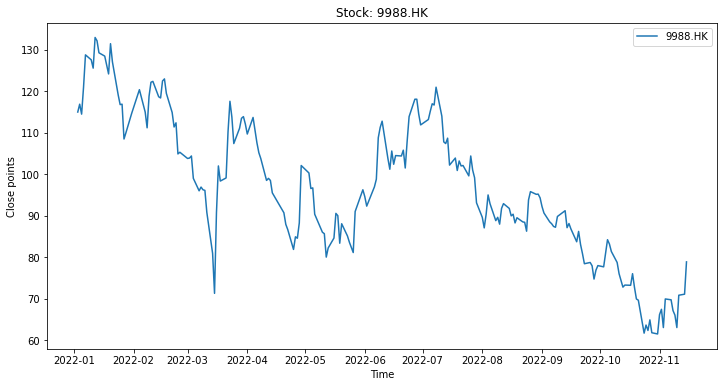

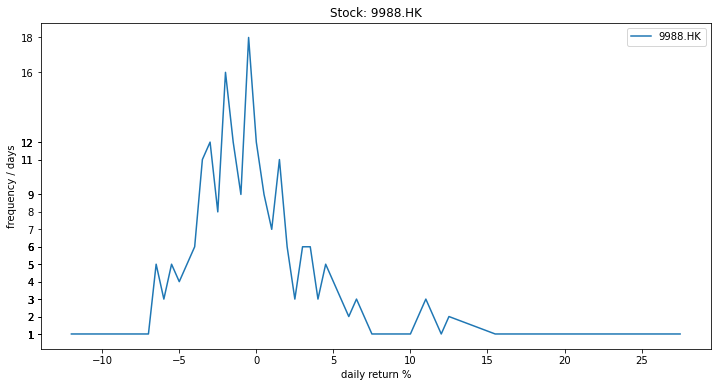

business days:  215
rise vs fall:  88 125


In [264]:
###
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團
i = 2022
tn = "9988.HK" # AAPL
st, et = str(i)+"-01-01", str(i)+"-12-31"
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)
#
line_date_close(df_data, tn)
distribution_close_return(df_data, tn)
#
pos_df = df_data[df_data['Close_return']>0]
neg_df = df_data[df_data['Close_return']<0]
#constant_df = df_data[df_data['Close_return']==0]
print( "business days: ", len(df_data) )
print( "rise vs fall: ", len(pos_df), len(neg_df) )

[*********************100%***********************]  1 of 1 completed


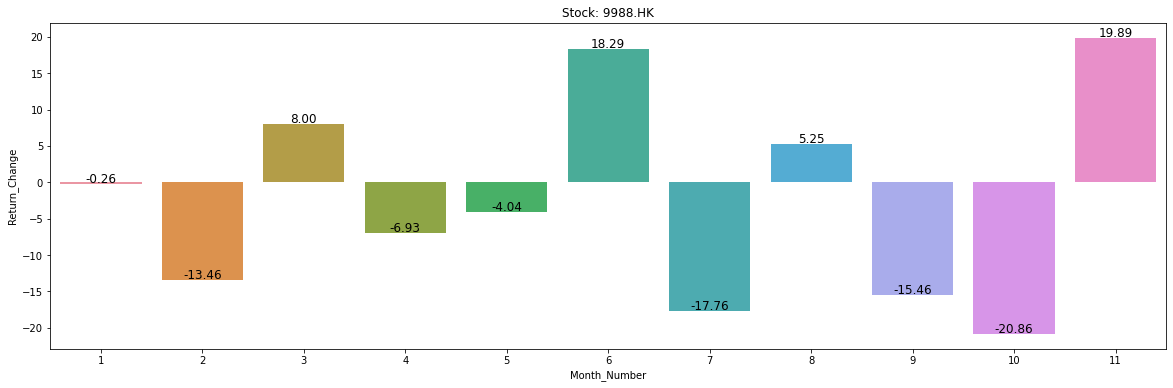

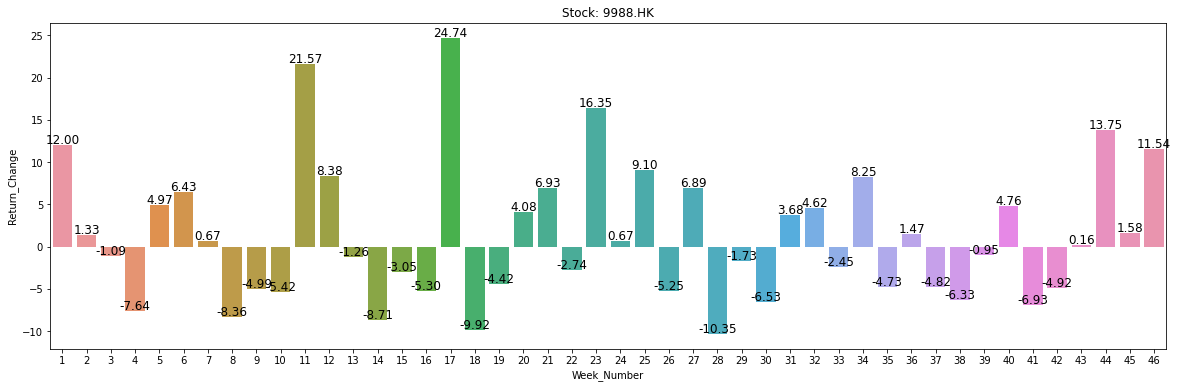

In [250]:
###
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團
i = 2022
tn = "9988.HK" # AAPL
st, et = str(i)+"-01-01", str(i)+"-12-31"
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)
df_data = get_ymt_date(df_data)
df_data

# monthly
x_axis, y_axis = month_change(df_data, "Close")
x_name, y_name = "Month_Number", "Return_Change"
draw_bar(x_axis, y_axis, x_name, y_name, tn)

# weekly
x_axis, y_axis = week_change(df_data, "Close")
x_name, y_name = "Week_Number", "Return_Change"
draw_bar(x_axis, y_axis, x_name, y_name, tn)

[*********************100%***********************]  1 of 1 completed


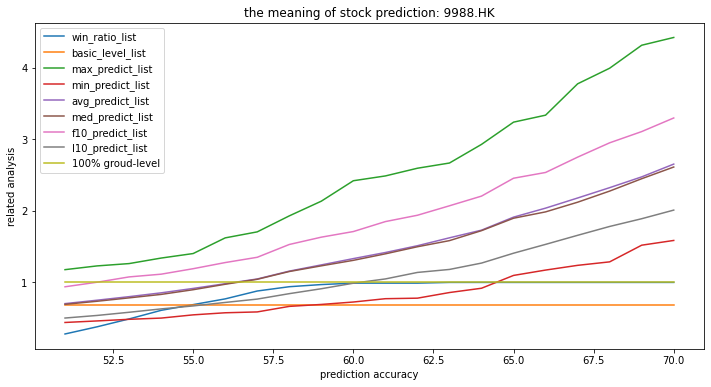

In [251]:
### 
predict_accuracy_list = []
win_ratio_list = []
basic_level_list = []
max_predict_list = []
min_predict_list = []
avg_predict_list = []
med_predict_list = []
f10_predict_list = []
l10_predict_list = []

# AAPL, AMZN, 
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團
tn = "9988.HK" 
for set_year in range(2022, 2023):
  i=set_year
  st, et = str(i)+"-01-01", str(i)+"-12-31"
  st, et = "2022-01-01", "2022-12-31"
  df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
  df_data = get_ymt_date(df_data)
  df_data = calculate_daily_return(df_data)
  df_data = get_market_movement(df_data)
  df_data = df_data.dropna()

  offset_profit = 0.10
  set_accuracy = 0.50
  for ii in range(20):
    set_accuracy += 0.01
    win_loss_list = []
    return_list = []
    for rs in range(200):
      buy_and_hold, profit, detail_operation = prediction_accuracy_meaning(df_data, random_seed=rs, accuracy_ratio=set_accuracy)
      #print( buy_and_hold, profit )
      if profit>buy_and_hold+offset_profit:
        win_loss_list.append(1)
      else:
        win_loss_list.append(0)
      return_list.append( profit )
    win, loss = sum(win_loss_list), len(win_loss_list)-sum(win_loss_list)
    mx, mn, avg, med, first_10, last_10 = statistical_indicators(return_list)
    #max_profit, min_profit, avg_profit = round(max(return_list), 2), round(min(return_list), 2), round(sum(return_list)/len(return_list), 2)
    #print(set_year, "\t", round(set_accuracy*100), "% accuracy \t", win, loss, round(win/(win+loss)*100, 2))
    #print("\t", max_profit, min_profit, avg_profit, round(buy_and_hold, 2))
    #
    predict_accuracy_list.append( round(set_accuracy*100) )
    win_ratio_list.append( round(win/(win+loss), 2) )
    basic_level_list.append( round(buy_and_hold, 2) )
    max_predict_list.append( mx )
    min_predict_list.append( mn )
    avg_predict_list.append( avg )
    med_predict_list.append( med )
    f10_predict_list.append( first_10 )
    l10_predict_list.append( last_10 )
# 
fig = plt.subplots(figsize =(12, 6))
plt.plot(predict_accuracy_list, win_ratio_list, label ='win_ratio_list') # , color ='r'
plt.plot(predict_accuracy_list, basic_level_list, label ='basic_level_list')
plt.plot(predict_accuracy_list, max_predict_list, label ='max_predict_list')
plt.plot(predict_accuracy_list, min_predict_list, label ='min_predict_list')
plt.plot(predict_accuracy_list, avg_predict_list, label ='avg_predict_list')
plt.plot(predict_accuracy_list, med_predict_list, label ='med_predict_list')
plt.plot(predict_accuracy_list, f10_predict_list, label ='f10_predict_list')
plt.plot(predict_accuracy_list, l10_predict_list, label ='l10_predict_list')
plt.plot(predict_accuracy_list, [1]*len(win_ratio_list), label ='100% groud-level')

plt.title("the meaning of stock prediction: " + tn)
plt.xlabel('prediction accuracy')
plt.ylabel("related analysis")

plt.legend()
plt.show()

In [268]:
### 
st, et = str(i)+"-01-01", str(i)+"-12-31"
st, et = "2022-11-11", "2022-11-14"

tn = "9988.HK" # AAPL
year = 2022
date_list = get_dates_from_range("01-01-"+str(year), "31-12-"+str(year))
i = 314 # 261, 315

high_dic, low_dic = {}, {}

for i in range(261, 315): # 
    st, et = date_list[i], date_list[i+1]
    print(st, et)
    # intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et) 
    df_data = get_df_data_update(ticker_name=tn, start_time=st, end_time=et, interval_len="30m")
    if len(df_data) != 12:
        continue
    df_data = get_ymt_date(df_data)

    mx_ind = find_index_max(df_data['High'])
    row = df_data.iloc[mx_ind]
    high_point, hm_time = round(row['High'],2), row['hour_minute']
    #print(mx_ind, high_point, hm_time)
    if mx_ind not in high_dic:
        high_dic[mx_ind] = 1
    else:
        high_dic[mx_ind] += 1

    mn_ind = find_index_min(df_data['Low'])
    row = df_data.iloc[mn_ind]
    low_point, lm_time = round(row['Low'],2), row['hour_minute']
    #print(mn_ind, low_point, lm_time)
    if mn_ind not in low_dic:
        low_dic[mn_ind] = 1
    else:
        low_dic[mn_ind] += 1

df_data

2022-09-19 2022-09-20
[*********************100%***********************]  1 of 1 completed
2022-09-20 2022-09-21
[*********************100%***********************]  1 of 1 completed
2022-09-21 2022-09-22
[*********************100%***********************]  1 of 1 completed
2022-09-22 2022-09-23
[*********************100%***********************]  1 of 1 completed
2022-09-23 2022-09-24
[*********************100%***********************]  1 of 1 completed
2022-09-24 2022-09-25
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 9988.HK: No data found for this date range, symbol may be delisted
2022-09-25 2022-09-26
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 9988.HK: No data found for this date range, symbol may be delisted
2022-09-26 2022-09-27
[*********************100%***********************]  1 of 1 completed
2022-09-27 2022-09-28
[*********************100%***********************]  1 of 1 completed
202

,Open,High,Low,Close,Adj Close,Volume,ymd_time,hour_minute,monthNumber,weekNumber
Datetime,,,,,,,,,,
2022-11-11 09:30:00,68.750000,69.400002,67.050003,67.150002,67.150002,12836959,2022-11-11,09:30,11,45
2022-11-11 10:00:00,67.199997,68.000000,67.199997,67.550003,67.550003,9141651,2022-11-11,10:00,11,45
2022-11-11 10:30:00,67.550003,68.449997,67.500000,68.199997,68.199997,6965974,2022-11-11,10:30,11,45
2022-11-11 11:00:00,68.150002,68.199997,67.699997,68.000000,68.000000,3620172,2022-11-11,11:00,11,45
2022-11-11 11:30:00,67.949997,68.150002,67.349998,67.550003,67.550003,2898625,2022-11-11,11:30,11,45
2022-11-11 13:00:00,67.550003,68.250000,67.250000,68.250000,68.250000,4690121,2022-11-11,13:00,11,45
2022-11-11 13:30:00,68.250000,70.150002,68.199997,69.949997,69.949997,18691902,2022-11-11,13:30,11,45
2022-11-11 14:00:00,69.949997,71.449997,69.550003,69.599998,69.599998,10246870,2022-11-11,14:00,11,45
2022-11-11 14:30:00,69.599998,70.400002,69.500000,70.099998,70.099998,6157317,2022-11-11,14:30,11,45


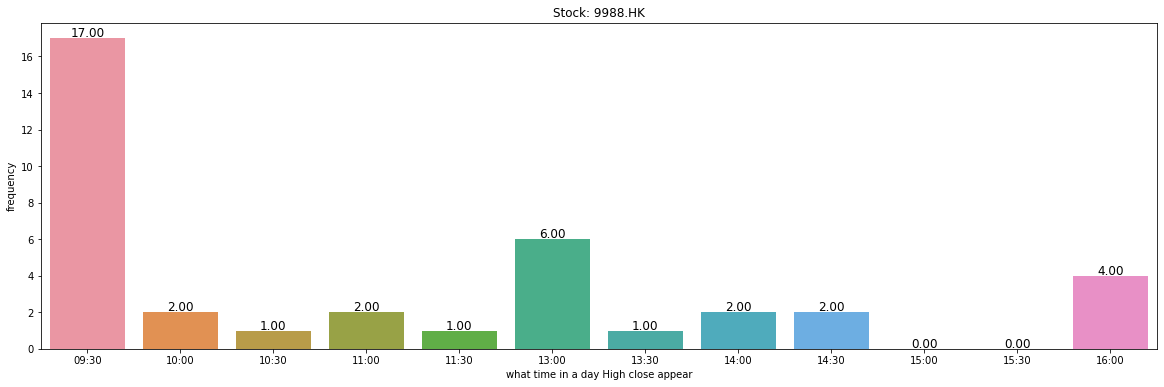

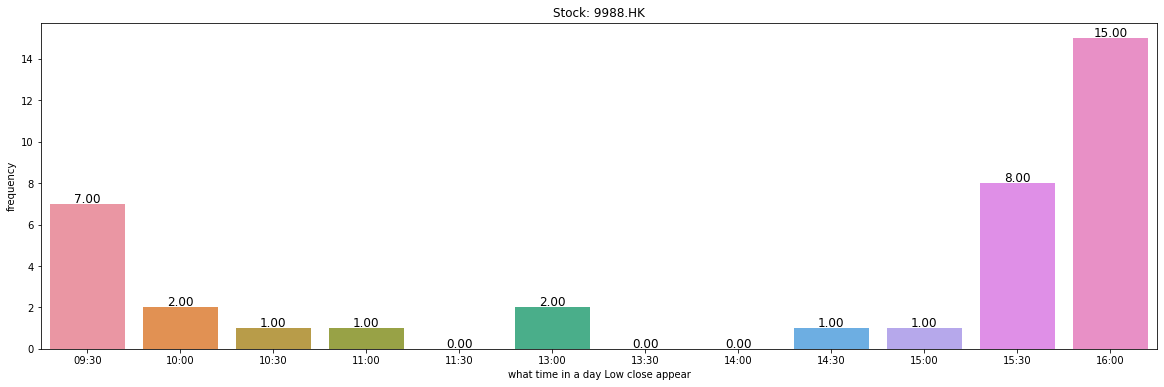

In [269]:
#
index_time = {
    0:'09:30', 1:'10:00', 2:'10:30', 3:'11:00',
    4:'11:30', 5:'13:00', 6:'13:30', 7:'14:00',
    8:'14:30', 9:'15:00', 10:'15:30', 11:'16:00'
}

index_time = [
    '09:30', '10:00', '10:30', '11:00', '11:30', '13:00', '13:30', '14:00','14:30', '15:00', '15:30', '16:00'
]

x_axis, y_axis = dic_to_xy(high_dic) # high_dic, low_dic
x_name, y_name = 'what time in a day High close appear', 'frequency'
draw_bar(x_axis, y_axis, x_name, y_name, tn, index_time)

x_axis, y_axis = dic_to_xy(low_dic) # high_dic, low_dic
x_name, y_name = 'what time in a day Low close appear', 'frequency'
draw_bar(x_axis, y_axis, x_name, y_name, tn, index_time)

38